In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets.mnist import load_data
import tqdm
from IPython.display import clear_output

In [0]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:
        output = layer.forward(input)
    
    - Propagate gradients through itself:
        grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during
    layer.backward.
    """
    def __init__(self):
        """
        Here you can initialize layer parameters (if any) and auxiliary stuff.
        """
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units],
        returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer,
        with respect to the given input.
        
        To compute loss gradients w.r.t input,
        you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input,
        so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer),
        you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output,
        # but we'll write it more explicitly
        num_units = input.shape[1]
        d_layer_d_input = np.eye(num_units)
        # chain rule
        return np.dot(grad_output, d_layer_d_input)

In [0]:
class ReLU(Layer):
    def __init__(self):
        """
        ReLU layer simply applies elementwise rectified linear unit to all
        inputs
        """
        pass
    
    def forward(self, input):
        """
        Apply elementwise ReLU to [batch, input_units] matrix
        """
        # <your code. Try np.maximum>
        return np.maximum(input, 0)
    
    def backward(self, input, grad_output):
        """
        Compute gradient of loss w.r.t. ReLU input
        """
        relu_grad = input > 0
        return grad_output*relu_grad

In [0]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine
        transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate

        # initialize weights with small random numbers.
        # We use normal initialization, 
        # but surely there is something better.
        # Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)

    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        # <your code here>
        return np.matmul(input, self.weights)+self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        # <your code here>
        grad_input = np.matmul(grad_output, self.weights.T)

        # compute gradient w.r.t. weights and biases
        # <your code here>
        grad_weights = np.matmul(input.T, grad_output)
        grad_biases = grad_output.sum(axis=0) 

        assert grad_weights.shape == self.weights.shape and\
        grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """
    Compute crossentropy from logits[batch,n_classes] and ids of correct
    answers
    """
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """
    Compute crossentropy gradient from logits[batch,n_classes] and ids of
    correct answers
    """
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

We're gonna use our framework to classify handwritten digits, so let's get them loaded.

11493376/11490434 [==============================] - 0s 0us/step


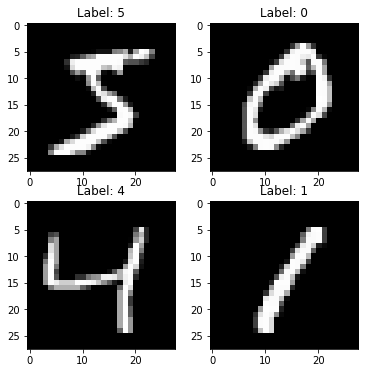

In [8]:
(X_train, y_train), (X_test, y_test) = load_data()
X_train = X_train.reshape([X_train.shape[0], -1])/255.
X_test = X_test.reshape([X_test.shape[0], -1])/255.
X_val, y_val = X_train[-10000:, :], y_train[-10000:]
X_train, y_train = X_train[:-10000, :], y_train[:-10000]

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray')

In [0]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    # <your code here>
    for i in range(len(network)):
        input = network[i].forward(input)
        activations.append(input)
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already
    made one gradient step.
    """
    # Get the layer activations
    layer_activations = forward(network,X)
    # layer_input[i] is an input for network[i]
    layer_inputs = [X]+layer_activations
    logits = layer_activations[-1]

    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

    # <your code: propagate gradients through the network>
    grad_output = loss_grad
    num_layer = len(network)
    for i in range(num_layer):
        grad_output = network[num_layer-i-1].\
        backward(layer_inputs[num_layer-i-1], grad_output)
    return np.mean(loss)

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [0]:
# workaround for https://github.com/tqdm/tqdm/issues/481
tqdm.monitor_interval = 0

class SimpleTqdm():
    def __init__(self, iterable=None, total=None, **kwargs):
        self.iterable = list(iterable) if iterable is not None else None
        self.total = len(self.iterable) if self.iterable is not None else total
        assert self.iterable is not None or self.total is not None
        self.current_step = 0
        self.print_frequency = max(self.total // 50, 1)
        self.desc = ""

    def set_description_str(self, desc):
        self.desc = desc

    def set_description(self, desc):
        self.desc = desc

    def update(self, steps):
        last_print_step = (self.current_step // self.print_frequency) *\
        self.print_frequency
        i = 1
        while last_print_step + i * self.print_frequency <=\
        self.current_step + steps:
            print("*", end='')
            i += 1
        self.current_step += steps

    def close(self):
        print("\n" + self.desc)

    def __iter__(self):
        assert self.iterable is not None
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.total:
            element = self.iterable[self.index]
            self.update(1)
            self.index += 1
            return element
        else:
            self.close()
            raise StopIteration


def tqdm_notebook_failsafe(*args, **kwargs):
    try:
        return tqdm.tqdm_notebook(*args, **kwargs)
    except:
        # tqdm is broken on Google Colab
        print('Call SimpleTqdm')
        return SimpleTqdm(*args, **kwargs)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_notebook_failsafe(range(0, len(inputs)-batchsize+1,
                                                  batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def get_shuffle_minbatch(data, label, batchsize):
  m = data.shape[0]
  ind_start = np.random.randint(m-batchsize)
  batch_data = data[ind_start: ind_start+batchsize, :]
  batch_label = label[ind_start: ind_start+batchsize]
  return batch_data, batch_label

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9797


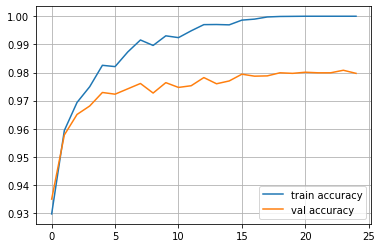

In [11]:
train_log = []
val_log = []

for epoch in range(25):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,
                                               batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()